# Fundamentals of Machine Learning (Supervised Learning)

This notebook was written with the desire to soldify machine learning knowledge learned from
* **CS170** --> Introduction to Machine Learning & Data Mining by Prof. Shelton
* **DeepLearning.ai & Stanford ONLINE** --> Machine Learning Specialization by Andrew Ng

In [1]:
# all modules used in this notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

# personal color pallete
c_map = {
    'red': '#ff6188',
    'orange': '#fc9867',
    'yellow': '#ffd866',
    'green': '#a8dd76',
    'blue': '#78dce8',
    'purple': '#ac9df2',
    'grey': '#2c2a2e',
    'white': '#fcfcfa',
    'black': '#211f22' 
}

# global params
matplotlib.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.facecolor'] = c_map['black']
plt.rcParams['axes.facecolor'] = c_map['black']
plt.rcParams['text.color'] = c_map['white']
plt.rcParams['axes.labelcolor'] = c_map['white']
plt.rcParams['xtick.color'] = c_map['white']
plt.rcParams['ytick.color'] = c_map['white']

## Data Generation

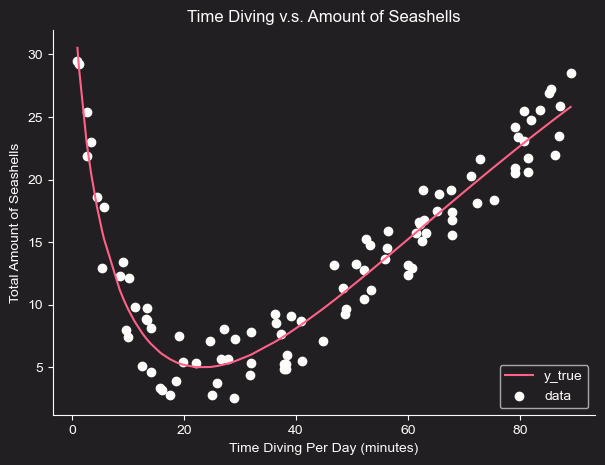

In [2]:
np.random.seed(1)
n_samples = 100

x_sample = np.round(np.sort(np.random.uniform(low=1, high=90, size=n_samples)), 2)
y_noise = np.random.uniform(low=-3, high=3, size=n_samples)
y_sample = -20*np.sin(x_sample**(1/3) + 5) + 25 + y_noise

y_true = -20*np.sin(x_sample**(1/3) + 5) + 25

# graph of data
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_sample, y_true, c=c_map['red'], label='y_true')
ax.scatter(x_sample, y_sample, c=c_map['white'], label='data')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_map['white'])
ax.set_title('Time Diving v.s. Amount of Seashells')
ax.set_xlabel('Time Diving Per Day (minutes)')
ax.set_ylabel('Total Amount of Seashells')
ax.legend(loc='lower right');

## Linear Regression

The hypothesis function is:
$$f(\vec{x}) = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$
$$f(\vec{x}) = \vec{w}^T\vec{x} + b$$

To simplify code implementation of linear regression, $w_0 = b$ is included in our weight vector. Now $f(\vec{x})$ is
$$f(\vec{x}) = w_0 + w_1x_1 + w_2x_2 ... + w_nx_n$$
Every example vector will have a scalar $1$ (representing $x_0$) in the first dimension to accomdate for the bias unit $w_0$


In [3]:
def lr_predict(X, w):
    return X @ w

X_sample = np.vstack([np.ones(x_sample.shape[0]), x_sample]).T
w_vec = [0, 1]
print(f'example [x_0, target]: {X_sample[3]}')
print(f'[bias, weight]: {w_vec}')
print(f'f(example) = {lr_predict(X_sample[3],w_vec)}')

example [x_0, target]: [1.   2.72]
[bias, weight]: [0, 1]
f(example) = 2.72


### Measurement of Error
The **loss** (squared error) for each example is defined as
$$L(w,\vec{x_i}) = (f(\vec{x_i}) - y_i)^2$$
where $f(\vec{x_i})$ is the predicted outcome made by model and $y_i$ is the observed outcome.

**Cost** function (mean squared error) is defined as
$$J(w,X) = \frac{1}{2m}\sum^{m - 1}_{i = 0}L(w,\vec{x_i})$$
The constant $2m$ is used instead of $m$ for cleaner partial derivative functions. The affect of dividing by $2$ does not impact the algorithm's inference accuracy.

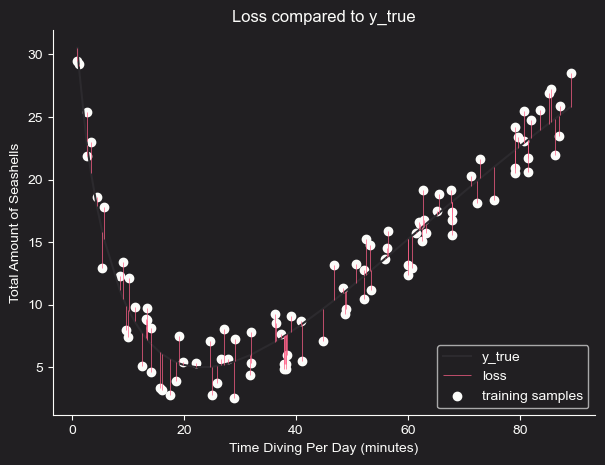

In [4]:
def lr_loss(y_hat, y):
    return (y_hat - y)**2

def lr_cost(y_hat, y):
    return np.sum((y_hat - y)**2)/(2*y.shape[0])

fig, ax = plt.subplots(figsize=(7,5))

y_mm = np.sort(np.vstack([y_sample, y_true]), axis=0)
ax.plot(x_sample, y_true, c=c_map['grey'], label='y_true')
ax.vlines(x=x_sample, ymin=y_mm[0], ymax=y_mm[1], color=c_map['red'], label='loss', linewidth=0.5)
ax.scatter(x_sample, y_sample, c=c_map['white'], label='training samples')

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_map['white'])
ax.set_title('Loss compared to y_true')
ax.set_xlabel('Time Diving Per Day (minutes)')
ax.set_ylabel('Total Amount of Seashells')
ax.legend(loc='lower right');
ax.legend(loc='lower right');

In [5]:
print(f'cost over all examples: {lr_cost(y_true, y_sample)}')

cost over all examples: 1.8042248271605508


Calculating the cost of the dataset reveals that even with the true mapping of x and y, you get MSE of 1.804 seashells. This will be the basis to compare how well our estimated model performs.

### Splitting Dataset

In [6]:
def train_test_split(X, y, p_train=0.6, get_index=False):
    n = X.shape[0]
    sample_indicies = np.arange(0, n)
    
    train_mask = np.random.choice(sample_indicies, size=int(p_train * n), replace=False)
    test_mask = sample_indicies[~np.isin(sample_indicies, train_mask)]
    
    if get_index:
        return X[train_mask], y[train_mask], X[test_mask], y[test_mask], train_mask, test_mask
    
    return X[train_mask], y[train_mask], X[test_mask], y[test_mask]

In [7]:
np.random.seed(1)
X_train, y_train, _X, _y, train_mask, _ = train_test_split(X_sample, y_sample, 0.6, get_index=True)
X_cv, y_cv, X_test, y_test, cv_mask, test_mask = train_test_split(_X, _y, 0.5, get_index=True) 

Now we have our have separated the dataset into
* **training set**: to train our model
* **cross validation set**: to evaluate our model + adjust for best performance
* **test set**: see how model performs to unseen data

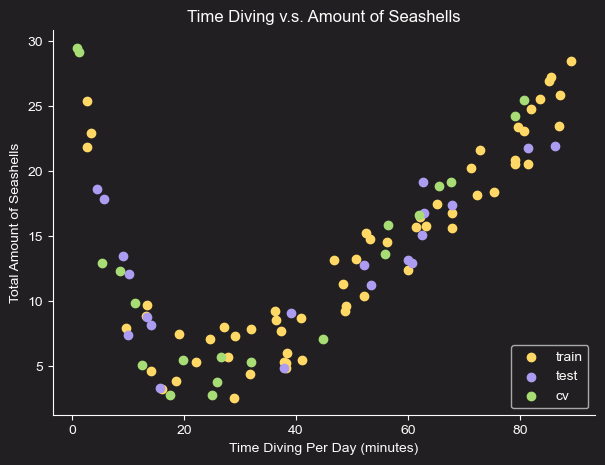

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:, 1], y_train, c=c_map['yellow'], label='train')
ax.scatter(X_test[:, 1], y_test, c=c_map['purple'], label='test')
ax.scatter(X_cv[:, 1], y_cv, c=c_map['green'], label='cv')


ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_map['white'])
ax.set_title('Time Diving v.s. Amount of Seashells')
ax.set_xlabel('Time Diving Per Day (minutes)')
ax.set_ylabel('Total Amount of Seashells')
ax.legend(loc='lower right');
ax.legend(loc='lower right');


### Gradient Descent

Gradient Descent is an alogirthm that optimizes the weight values by minimizing total loss.

The cost function expanded is
$$J(w,X) = \frac{1}{2m}\sum^{m - 1}_{i = 0}(w_0x_{0}^{(i)} + w_1x_{1}^{(i)} + ... + w_nx_{n}^{(i)} - y^{(i)})^2$$

Gradient is defined as
$$\nabla\vec{J} = \begin{pmatrix}
\\
\frac{dJ}{dw_0}\\\\
\frac{dJ}{dw_1} \\\\
.\\
.\\
. \\\\
\frac{dJ}{dw_n} \\ \\

\end{pmatrix}$$


Inorder to implement gradient descent, the the partial derivative w.r.t each variable must be defined.

$$\frac{dJ}{dw_j} = \frac{1}{m}\sum^{m - 1}_{i = 0}(\vec{w}^T\vec{x}^{(i)} - y^{(i)})x_{j}^{(i)}$$
$$\frac{dJ}{dw_0} = \frac{1}{m}\sum^{m - 1}_{i = 0}(\vec{w}^T\vec{x}^{(i)} - y^{(i)})$$



In [9]:
def lr_compute_gradient(X, y, w):
    m = X.shape[0]
    n = X.shape[1]
    
    y_hat = lr_predict(X, w)
    g_w = np.zeros(n)
    
    g_w[0] = np.sum(y_hat - y)/m
    
    for i in range(1, n):
        g_w[i] = np.sum((y_hat - y) * X[:, i])/m
    
    return g_w

The update rule for gradient descent is #TODO

In [ ]:
def lr_gradient_descent(X, y, w, eta=0.01, threshold=0.005, max_iter = 1000):
    m = X.shape[0]
    
    delta_cost = math.inf
    y_hat = lr_predict(X, w)
    old_cost = lr_cost(y_hat, y)
    max_delta = 1e+20
    
    cost_list = [old_cost]
    grad_norm_list = [0]
    
    iterations = 0
    while delta_cost >= threshold:
        
        iterations += 1
        g_w = lr_compute_gradient(X, y, w)
        grad_norm_list.append(np.sqrt(np.sum(g_w**2)))
        w = w - eta*g_w
        
        y_hat = lr_predict(X, w)
        new_cost = lr_cost(y_hat, y) 
        
        delta_cost = np.abs(old_cost - new_cost)
        cost_list.append(new_cost)
        old_cost = new_cost
        
        if delta_cost > max_delta:
            print(f'error: delta cost reached over {max_delta}')
            break
    
    print('compelete!')
    print(f'iterations: {iterations}')
    
    return (w, cost_list, grad_norm_list)

In [18]:
X_train_attempt = X_train.copy()
w_test, cost_test, grad_norm_test = lr_gradient_descent(X_train_attempt, y_train, w_vec);
print(f'weight values: {w_test}')

error: delta cost reached over 1e+20
compelete: algorithm converged
iterations: 6
weight values: [6.92958917e+06 4.25952713e+08]


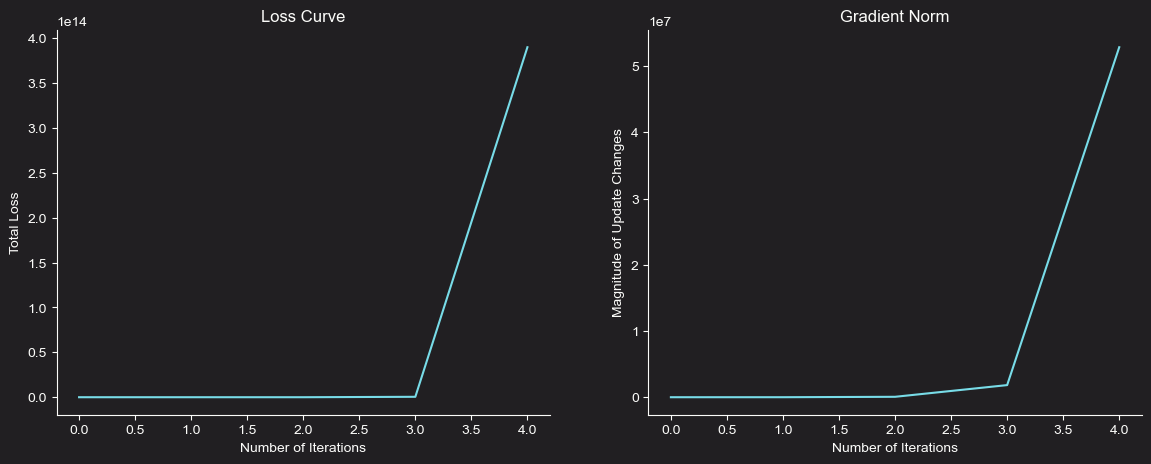

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
n_iter = np.arange(len(cost_test[:5]))
ax[0].plot(n_iter, cost_test[:5], c=c_map['blue'])
ax[1].plot(n_iter, grad_norm_test[:5], c=c_map['blue'])

ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Number of Iterations')
ax[0].set_ylabel('Total Loss')

ax[1].set_title('Gradient Norm')
ax[1].set_xlabel('Number of Iterations')
ax[1].set_ylabel('Magnitude of Update Changes')

for axes in ax.flat:
    axes.spines[['top', 'right']].set_visible(False)
    axes.spines[['bottom', 'left']].set_color(c_map['white'])

plt.show()

The gradient descent algorithm diverges and results in greater cost. The magnitude of the updates only increase. Too big learning rates or big feature values are usually the root cause of divergence. So, decreasing the learning rate and/or feature scaling are two ways to combat this problem.

In [13]:
def standard_scaler(X):
    return (X - np.mean(X, axis=0))/np.std(X, axis=0)

In [19]:
X_train_scaled = X_train.copy()
X_train_scaled[:, 1] = standard_scaler(X_train[:, 1])
w_learned, cost_learned, grad_learned = lr_gradient_descent(X_train_scaled, y_train, w_vec)
print(f'weight values: {w_learned}')

compelete: algorithm converged
iterations: 300
weight values: [13.02247549  4.85636642]


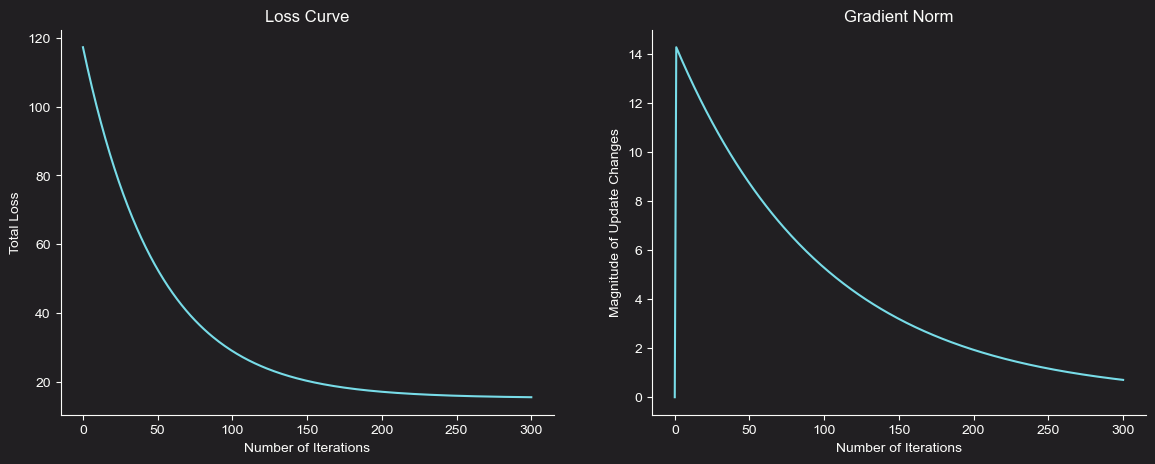

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))
n_iter = np.arange(len(cost_learned))
ax[0].plot(n_iter, cost_learned, c=c_map['blue'])
ax[1].plot(n_iter, grad_learned, c=c_map['blue'])

ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Number of Iterations')
ax[0].set_ylabel('Total Loss')

ax[1].set_title('Gradient Norm')
ax[1].set_xlabel('Number of Iterations')
ax[1].set_ylabel('Magnitude of Update Changes')

for axes in ax.flat:
    axes.spines[['top', 'right']].set_visible(False)
    axes.spines[['bottom', 'left']].set_color(c_map['white'])
    
plt.show()

Here, the loss curve as well as the gradient norm both display the algorithm approching a local minimum as cost decreases over time and the magnitude of gradient descent becoming smaller and smaller each step. The following is a plot of the fitted model.

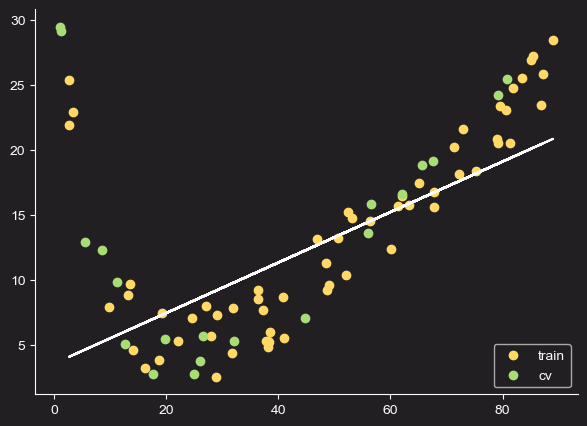

In [20]:
np.random.seed(1)

fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train[:, 1], y_train, c=c_map['yellow'], label='train')
ax.scatter(X_cv[:, 1], y_cv, c=c_map['green'], label='cv')
ax.plot(X_train[:, 1], lr_predict(X_train_scaled, w_learned), c=c_map['white'])

ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_color(c_map['white'])
ax.legend(loc='lower right');

As you can see:
* $J_{train}$ is quite high, showing **high bias** 
* $J_{cv}$ is quite high, showing **high variance**


### Model Diagnostics & Tuning
* increase degree by adding a variable -->
* show overfitting to training data noise
* show bias vs variance graph with minimum variance using L_cv
* pick the degree two
* now try with test dataz

#### Bias vs. Variance Trade-off

#### Regularization

### Testing Model Performance

## Logistic Regression

* error analysis: look at a specific example that is being mis calssified
* classification metrics

hyperparameter tuning (cv_cost & train_cost) -> pick minimum cv_cost